## 3. Data Calculation

In [63]:
# Connect to cur and conn again
import os
import sqlite3

def open_database(db_name):
    current_folder = globals()['_dh'][0]
    full_path = os.path.join(current_folder, db_name)
    conn = sqlite3.connect(full_path)
    cur = conn.cursor()
    return cur, conn
cur,conn = open_database('company_stock.db')


In [64]:
def extract_Data(company):
    # Join the tables on date and retrieve the columns we need
    query = f"""
    SELECT {company}.date, {company}.close, SP500.close
    FROM {company}
    JOIN SP500 ON {company}.date = SP500.date
    """

    cur.execute(query)
    rows = cur.fetchall()

    # Extract the data from the query results
    dates = [row[0] for row in rows]
    company_close = [row[1] for row in rows]
    sp500_close = [row[2] for row in rows]
    return dates,company_close,sp500_close

In [65]:
def get_roc(company_close,sp500_close):
    company_roc = []
    for i in range(len(company_close)-1):
        roc = (company_close[i+1] - company_close[i]) / company_close[i]
        company_roc.append(roc)
    sp500_roc = []
    for i in range(len(sp500_close)-1):
        roc = (sp500_close[i+1] - sp500_close[i]) / sp500_close[i]
        sp500_roc.append(roc)
    return company_roc,sp500_roc

In [66]:
import csv
def write_to_file(which_company, dates, company_roc, sp500_roc):
    # rate of change, only keeps date after ward
    dates.pop(0)
    filename = which_company + "_roc.csv"
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Date', 'Company ROC', 'S&P500 ROC'])
        for i in range(len(dates)):
            writer.writerow([dates[i], company_roc[i], sp500_roc[i]])

### Generate output into a new csv File

In [67]:
company_list = ['AAPL','MSFT','CVX','XOM', 'JNJ','LLY']
for company in company_list:
    dates, company_close,sp500_close = extract_Data(company)
    company_roc,sp500_roc = get_roc(company_close,sp500_close)
    write_to_file(company, dates, company_roc, sp500_roc)

In [68]:
# Read the CSV file and insert the remaining rows into the database
def read_new_csv_to_db(csv_file,cur,conn):
    query = f"CREATE TABLE IF NOT EXISTS {csv_file} (date DATE PRIMARY KEY, company_roc DOUBLE, snp_roc DOUBLE)"
    cur.execute(query)
    with open(csv_file + '.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header row
        for row in reader:         
            query = f"INSERT OR IGNORE INTO {csv_file} (date, company_roc,snp_roc) VALUES (?,?,?)"       
            cur.execute(query,(row))

    # Commit changes and close the database connection
    conn.commit()

### Calculation

In [69]:
gap_snp_company = []
for company in company_list:
    query = f"DROP TABLE IF EXISTS {company+ '_roc'}"
    cur.execute(query)
    read_new_csv_to_db(company + '_roc',cur,conn)
    query = f"ALTER TABLE {company+ '_roc'} ADD COLUMN gap DOUBLE"
    cur.execute(query)
    query = f"UPDATE {company+'_roc'} SET gap = company_roc - snp_roc"
    cur.execute(query)
    query = f"SELECT AVG(gap) FROM {company+'_roc'}"
    cur.execute(query)
    gap_snp_company.append(abs(cur.fetchone()[0]))
    conn.commit()

# 4. Data Visualization

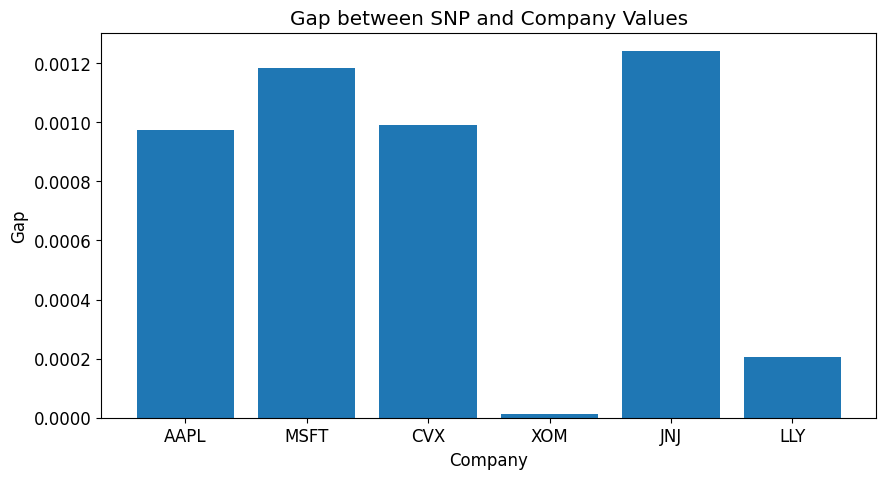

In [70]:
import matplotlib.pyplot as plt

# Set the figure size and font size
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 12})

# Create a bar plot with the company names on the x-axis
plt.bar(company_list, gap_snp_company)

# Set the title and axis labels
plt.title('Gap between SNP and Company Values')
plt.xlabel('Company')
plt.ylabel('Gap')

# Show the plot
plt.show()


In [71]:
import numpy as np
from datetime import datetime
def graph_trend(dates, company_roc, sp500_roc, company_name):
    np_dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates]
    # Plot the data on a line graph
    plt.plot(dates, company_roc, label=company_name)
    plt.plot(dates, sp500_roc, label='S&P 500')
    plt.xlabel('Date')
    xticks_pos = np.arange(0, len(dates), 9)
    xticks_labels = [np_dates[i].strftime('%Y-%m-%d') for i in xticks_pos]
    plt.xticks(xticks_pos, xticks_labels, rotation=90)
    plt.ylabel('Rate of Change in Closing Price')
    plt.title(company_name)
    plt.legend()
    plt.show()

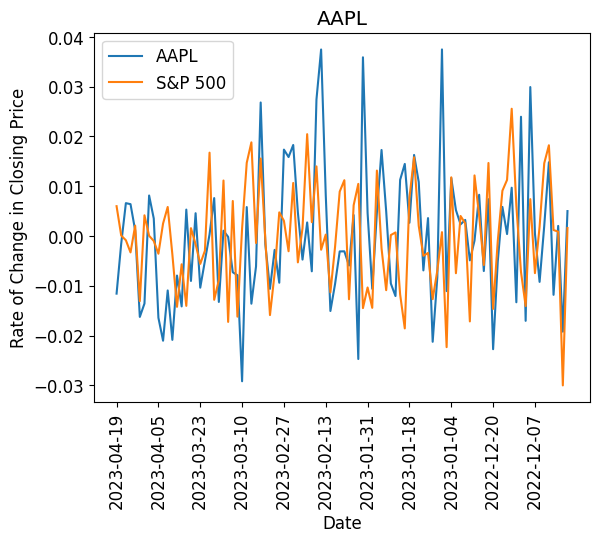

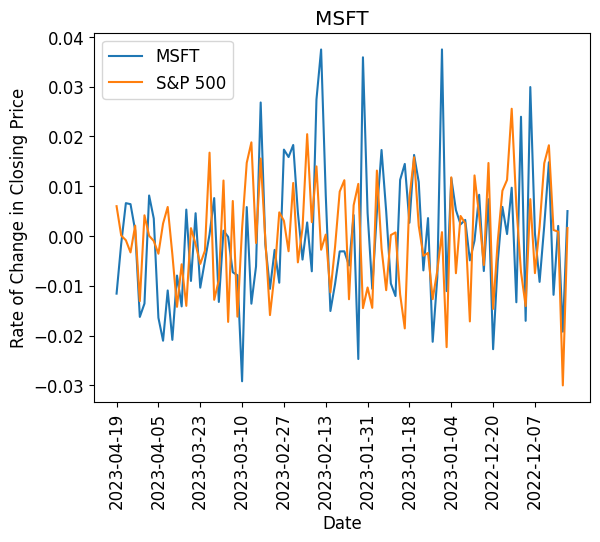

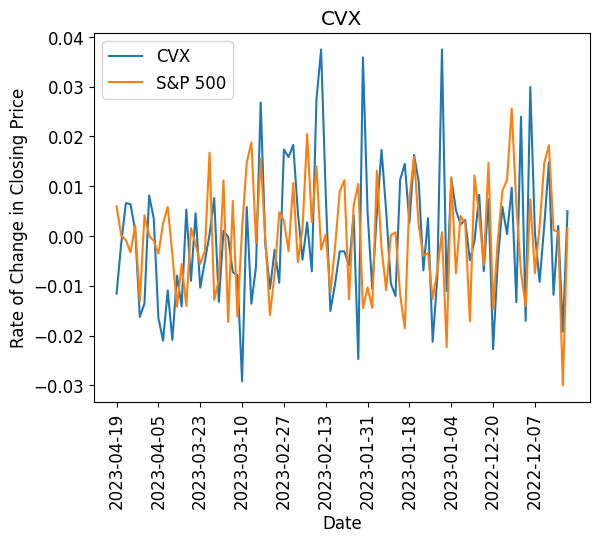

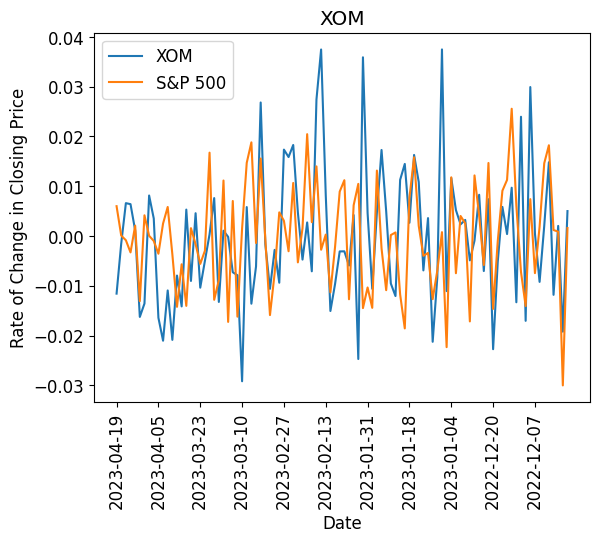

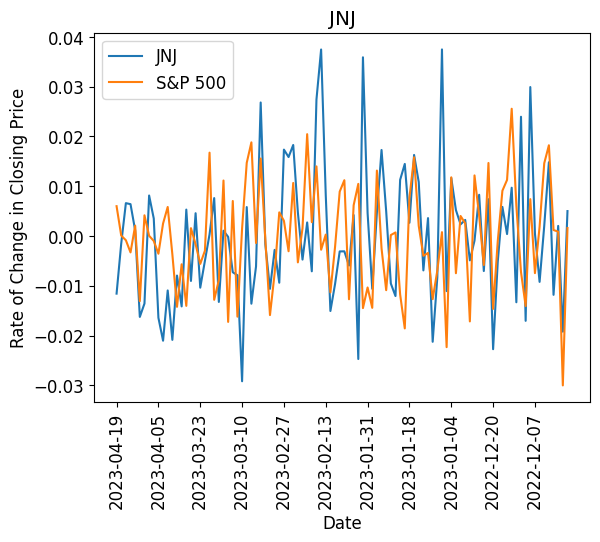

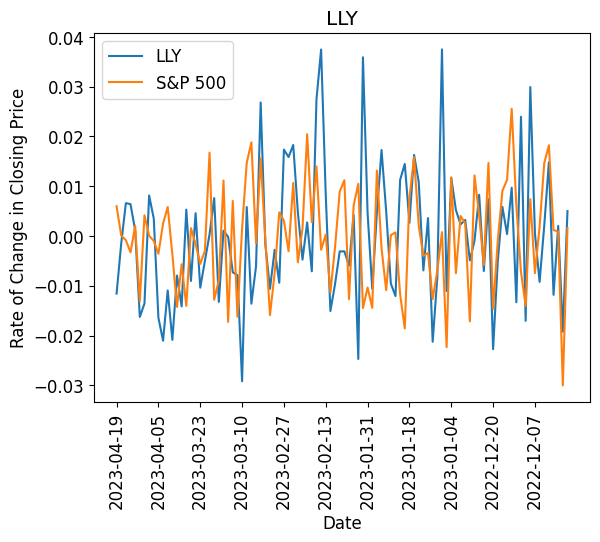

In [72]:
for company in company_list:
    graph_trend(dates, company_roc, sp500_roc, company)